# 1. 라이브러리 호출

In [1]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf  # 이미 위에서 가져왔다면 'import tensorflow as tf' 줄을 제거할 수 있습니다
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, initializers, regularizers, metrics
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from glob import glob
from PIL import Image
import numpy as np


# 2. 데이터 로드 및 전처리

In [2]:
caltech_dir = "/Users/stepground/Inha-Project/VGG/Images"
categories = ["bodylower","sit"]
nb_classes = len(categories)

In [3]:
image_w = 128
image_h = 128

pixels = image_h * image_w * 3

X = []
y = []

In [4]:
for idx, cat in enumerate(categories):
    
    #one-hot encoding
    label = [0 for i in range(nb_classes)]
    label[idx] = 1

    image_dir = caltech_dir + "/" + cat
    files = glob(image_dir+"/*.jpg")
    
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)
        
        X.append(data)
        y.append(label)

        
        if i % 1000 == 0:
            print(cat, " : ", f)

bodylower  :  /Users/stepground/Inha-Project/VGG/Images/bodylower/bodylower_3_231.jpg
bodylower  :  /Users/stepground/Inha-Project/VGG/Images/bodylower/bodylower_3_456.jpg
bodylower  :  /Users/stepground/Inha-Project/VGG/Images/bodylower/bodylower_3_1170.jpg
sit  :  /Users/stepground/Inha-Project/VGG/Images/sit/sit_4_932.jpg
sit  :  /Users/stepground/Inha-Project/VGG/Images/sit/sit_4_1458.jpg


In [5]:
X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

xy = (X_train, X_test, y_train, y_test)

#일반화
X_train = X_train.astype(float) / 255
X_test = X_test.astype(float) / 255

In [6]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3555, 128, 128, 3)
(1186, 128, 128, 3)
(3555, 2)
(1186, 2)


# 3. 모델링

In [7]:
input_tensor = Input(shape=(128, 128, 3), dtype='float32', name='input')

#vgg16 모델 불러오기
pre_trained_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
pre_trained_vgg.trainable = False
pre_trained_vgg.summary()

#vgg16 밑에 레이어 추가
additional_model = models.Sequential()
additional_model.add(pre_trained_vgg)
additional_model.add(layers.Flatten())
additional_model.add(layers.Dense(4096, kernel_regularizer = regularizers.l1_l2
                                  (l1=0.001,l2=0.001),activation='relu'))
additional_model.add(layers.Dropout(0.5))
additional_model.add(layers.Dense(2048, kernel_regularizer = regularizers.l1_l2
                                  (l1=0.001,l2=0.001),activation='relu'))
additional_model.add(layers.Dropout(0.5))
additional_model.add(layers.Dense(1024, kernel_regularizer = regularizers.l1_l2
                                  (l1=0.001,l2=0.001),activation='relu'))
additional_model.add(layers.Dropout(0.5))
additional_model.add(layers.Dense(512, kernel_regularizer = regularizers.l1_l2
                                  (l1=0.001,l2=0.001),activation='relu'))
additional_model.add(layers.Dropout(0.5))
additional_model.add(layers.Dense(256, kernel_regularizer = regularizers.l1_l2
                                  (l1=0.001,l2=0.001),activation='relu'))
additional_model.add(layers.Dropout(0.5))
additional_model.add(layers.Dense(128, kernel_regularizer = regularizers.l1_l2
                                  (l1=0.001,l2=0.001),activation='relu'))
additional_model.add(layers.Dropout(0.5))
additional_model.add(layers.Dense(2, activation='softmax'))

additional_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [8]:
additional_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 4096)              33558528  
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 2048)              8390656   
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              2

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',  # 손실 값을 모니터링합니다.
                               patience=5,         # 5 에포크 동안 개선이 없으면 중지합니다.
                               verbose=1,          # 중지되면 메시지를 출력합니다.
                               restore_best_weights=True)  # 최적 가중치로 복원합니다.

history = additional_model.fit(X_train, y_train, 
                               batch_size=50, 
                               epochs=30, 
                               validation_data=(X_test, y_test),
                               callbacks=[early_stopping])  # EarlyStopping 콜백을 적용합니다.

Epoch 1/30
72/72 [==============================] - 11s 120ms/step - loss: 168.6517 - acc: 0.5179 - val_loss: 59.8098 - val_acc: 0.5944
Epoch 2/30
72/72 [==============================] - 7s 100ms/step - loss: 38.2701 - acc: 0.5778 - val_loss: 26.7195 - val_acc: 0.5944
Epoch 3/30
72/72 [==============================] - 7s 100ms/step - loss: 24.1663 - acc: 0.5893 - val_loss: 23.5459 - val_acc: 0.5944
Epoch 4/30
72/72 [==============================] - 7s 100ms/step - loss: 23.1148 - acc: 0.5893 - val_loss: 23.1835 - val_acc: 0.5944
Epoch 5/30
72/72 [==============================] - 7s 100ms/step - loss: 23.0511 - acc: 0.5893 - val_loss: 23.8986 - val_acc: 0.5944
Epoch 6/30
72/72 [==============================] - 7s 99ms/step - loss: 23.0506 - acc: 0.5893 - val_loss: 24.1543 - val_acc: 0.5944
Epoch 7/30
72/72 [==============================] - 7s 99ms/step - loss: 23.0499 - acc: 0.5893 - val_loss: 23.4611 - val_acc: 0.5944
Epoch 8/30
72/72 [==============================] - 7s 99ms/st

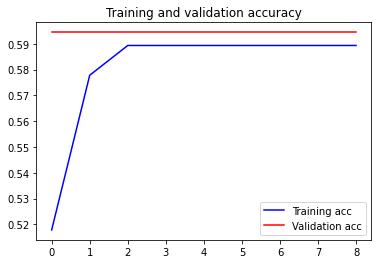

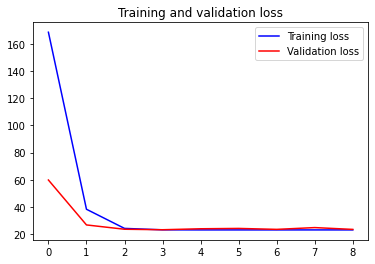

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()